# Clustering and Segmentation of Bengaluru neighbourhood

### This notebook performs the clustering and segmentation of Bengaluru neighbourhood using the data from foursquare

## Part 1 : Install the dependencies 

In [78]:
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

In [79]:
import pandas as pd
import numpy as np # library to handle data in a vectorized manner
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import rcParams

import matplotlib.pyplot as plt
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans


### ----- End of Part 1 --- 

   ***

## Part 2 : Fetch the Geo location of the localities in Bengaluru

### Fetching the Geo-location (Latitude and Longitude) from the csv imported to Watson Studio and save the data in a dataframe

In [80]:
# The code was removed by Watson Studio for sharing.

,Locality,Latitude,Longitude
0,BTM,12.916576,77.610116
1,Banashankari,12.925453,77.546757
2,Banaswadi,13.010376,77.648194
3,Bannerghatta Road,12.839527,77.588861
4,Basavanagudi,12.940600,77.573763


### --- End of Part 2  ------

---

## Part 3 : Explore and cluster the neighborhoods in Bengaluru

#### Display the dataframe containing details of localities of bengaluru

In [81]:
blore_geo_df.head()


,Locality,Latitude,Longitude
0,BTM,12.916576,77.610116
1,Banashankari,12.925453,77.546757
2,Banaswadi,13.010376,77.648194
3,Bannerghatta Road,12.839527,77.588861
4,Basavanagudi,12.940600,77.573763


In [82]:
blore_geo_df.shape

(85, 3)

### Fetch coordinates of Bengaluru

In [83]:
address = 'Bengaluru, IN'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bengaluru are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bengaluru are 12.9791198, 77.5912997.


In [84]:
# create map of Bengaluru using latitude and longitude values
map_bengaluru = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(blore_geo_df['Latitude'], blore_geo_df['Longitude'], blore_geo_df['Locality']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bengaluru)  
    
map_bengaluru

In [85]:
#Define Foursquare Credentials


## Explore the localities of Bengaluru in our dataframe using Foursquare API.

#### Let's create a function to analyse all the localities in Bengaluru

In [86]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    food_category = '4d4b7105d754a06374d81259' # 'Root' category for all food-related venues
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            food_category,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Locality', 
                  'Locality Latitude', 
                  'Locality Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [87]:
blore_venues = getNearbyVenues(names=blore_geo_df['Locality'],
                                   latitudes=blore_geo_df['Latitude'],
                                   longitudes=blore_geo_df['Longitude']
                                  )

In [88]:
print(blore_venues.shape)
blore_venues.head()

(1334, 7)


,Locality,Locality Latitude,Locality Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,BTM,12.916576,77.610116,McDonald's,12.915874,77.610119,Fast Food Restaurant
1,BTM,12.916576,77.610116,Adyar Ananda Bhavan (A2B),12.916653,77.609745,Vegetarian / Vegan Restaurant
2,BTM,12.916576,77.610116,New Friends rooftop euro restaurant,12.916651,77.612409,Restaurant
3,BTM,12.916576,77.610116,Gyani Da Punjabi Dhaba,12.916176,77.612200,Indian Restaurant
4,BTM,12.916576,77.610116,Subway,12.916789,77.612366,Sandwich Place


In [89]:
blore_venues.groupby('Locality').count()

,Locality Latitude,Locality Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Locality,,,,,,
BTM,31,31,31,31,31,31
Banashankari,12,12,12,12,12,12
Banaswadi,5,5,5,5,5,5
Bannerghatta Road,2,2,2,2,2,2
Basavanagudi,29,29,29,29,29,29
Basaveshwara Nagar,17,17,17,17,17,17
Bellandur,5,5,5,5,5,5
Bommanahalli,4,4,4,4,4,4
Brigade Road,76,76,76,76,76,76


In [90]:
print('There are {} uniques categories.'.format(len(blore_venues['Venue Category'].unique())))

There are 78 uniques categories.


## Explore the localities of Bengaluru in our dataframe using Zomato API.

In [91]:

body = client_e936c8ffbaa346608ae9f7f0e67801d4.get_object(Bucket='datasciencecapstoneproject-donotdelete-pr-kdprgw7j26k3c0',Key='zomato.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

zomato_df = pd.read_csv(body)
zomato_df.head()


,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [92]:
zomato_df.shape

(51717, 17)

#### Data Cleansing of the data to get only the required columns

In [99]:
## Extract only the name, rest_type, location, rate, rest_type from the input dataframe
zomato_df.dropna(subset= ["location"], inplace=True)
zomato_proc_df=zomato_df[['name','location','rest_type','rate']]
print(zomato_proc_df.shape)
zomato_proc_df.head()

(51696, 4)


,name,location,rest_type,rate
0,Jalsa,Banashankari,Casual Dining,4.1/5
1,Spice Elephant,Banashankari,Casual Dining,4.1/5
2,San Churro Cafe,Banashankari,"Cafe, Casual Dining",3.8/5
3,Addhuri Udupi Bhojana,Banashankari,Quick Bites,3.7/5
4,Grand Village,Basavanagudi,Casual Dining,3.8/5


As you can see the rate column is string type with an extra /5 with all the ratings. This should be cleaned.It is important to convert the string back to float !!

In [100]:
X = zomato_proc_df
X.rate = X.rate.replace("NEW", np.nan)
X.rate = X.rate.replace("-", np.nan)
X.rate = X.rate.astype(str)
X.rate = X.rate.apply(lambda x: x.replace('/5',''))
X.rate = X.rate.apply(lambda x: float(x))
X.head()

,name,location,rest_type,rate
0,Jalsa,Banashankari,Casual Dining,4.1
1,Spice Elephant,Banashankari,Casual Dining,4.1
2,San Churro Cafe,Banashankari,"Cafe, Casual Dining",3.8
3,Addhuri Udupi Bhojana,Banashankari,Quick Bites,3.7
4,Grand Village,Basavanagudi,Casual Dining,3.8


For our analysis lets consider only resturants that are rated higher than 3.7

In [101]:
zomato_proc_df = X[X['rate'] >= 3.7]
print(' Number of resturants with rating more than 3.7 : ' + str(len(zomato_proc_df.index)))


 Number of resturants with rating more than 3.7 : 24065


In [102]:
zomato_proc_df.rename(columns={'location': 'Locality','rest_type': 'Venue Category', 'name': 'Venue'}, inplace=True)
del zomato_proc_df['rate']
# Collate all the areas of Koramanagala into 1. 
zomato_proc_df.replace(to_replace='Koramangala.*',value='Koramangala',inplace=True,regex=True)
zomato_proc_df.replace(to_replace='ITPL Main Road, Whitefield',value='Whitefield',inplace=True,regex=True)
zomato_proc_df.replace(to_replace='Varthur Main Road, Whitefield',value='Whitefield',inplace=True,regex=True)
zomato_proc_df = zomato_proc_df.reset_index(drop=True)
zomato_proc_df.shape


(24065, 3)

In [103]:
# Remove the duplicated rows in the dataset
duplicateRowsDF = zomato_proc_df[zomato_proc_df.duplicated()]
 
print("Number of Duplicate Rows are : " + str(len(duplicateRowsDF.index)))

zomato_proc_df = zomato_proc_df.drop_duplicates()
print(zomato_proc_df.shape)

Number of Duplicate Rows are : 19239
(4826, 3)


In [104]:
zomato_proc_merge = pd.merge(zomato_proc_df,blore_geo_df, how='left', on= ['Locality'])
zomato_proc_merge.rename(columns={'Latitude': 'Locality Latitude','Longitude': 'Locality Longitude'}, inplace=True)
zomato_proc_merge

,Venue,Locality,Venue Category,Locality Latitude,Locality Longitude
0,Jalsa,Banashankari,Casual Dining,12.925453,77.546757
1,Spice Elephant,Banashankari,Casual Dining,12.925453,77.546757
2,San Churro Cafe,Banashankari,"Cafe, Casual Dining",12.925453,77.546757
3,Addhuri Udupi Bhojana,Banashankari,Quick Bites,12.925453,77.546757
4,Grand Village,Basavanagudi,Casual Dining,12.940600,77.573763
5,Timepass Dinner,Basavanagudi,Casual Dining,12.940600,77.573763
6,Onesta,Banashankari,"Casual Dining, Cafe",12.925453,77.546757
7,Penthouse Cafe,Banashankari,Cafe,12.925453,77.546757
8,Smacznego,Banashankari,Cafe,12.925453,77.546757
9,CafÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ© Down The A...,Banashankari,Cafe,12.925453,77.546757


In [105]:
zomato_proc_merge['Venue Latitude'] = zomato_proc_merge['Locality Latitude']
zomato_proc_merge['Venue Longitude'] = zomato_proc_merge['Locality Longitude']

In [106]:
#Merge all the zomato resturants to previously identified resturants from Foursquare APIs
blore_venues = blore_venues.append(zomato_proc_merge, ignore_index=True, sort=False)
blore_venues

,Locality,Locality Latitude,Locality Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,BTM,12.916576,77.610116,McDonald's,12.915874,77.610119,Fast Food Restaurant
1,BTM,12.916576,77.610116,Adyar Ananda Bhavan (A2B),12.916653,77.609745,Vegetarian / Vegan Restaurant
2,BTM,12.916576,77.610116,New Friends rooftop euro restaurant,12.916651,77.612409,Restaurant
3,BTM,12.916576,77.610116,Gyani Da Punjabi Dhaba,12.916176,77.612200,Indian Restaurant
4,BTM,12.916576,77.610116,Subway,12.916789,77.612366,Sandwich Place
5,BTM,12.916576,77.610116,Marwa Restuarant,12.914572,77.610092,Indian Restaurant
6,BTM,12.916576,77.610116,Flavours of China,12.913776,77.607662,Chinese Restaurant
7,BTM,12.916576,77.610116,Momoz,12.913854,77.608928,Dim Sum Restaurant
8,BTM,12.916576,77.610116,Amma's Pastries,12.913941,77.609944,Bakery
9,BTM,12.916576,77.610116,Cafe Coffee Day,12.916634,77.606486,Café


## Data Visualization

### Are the locations of restaurants localised to specific parts of city?

Text(0.5, 1.0, 'Locality')

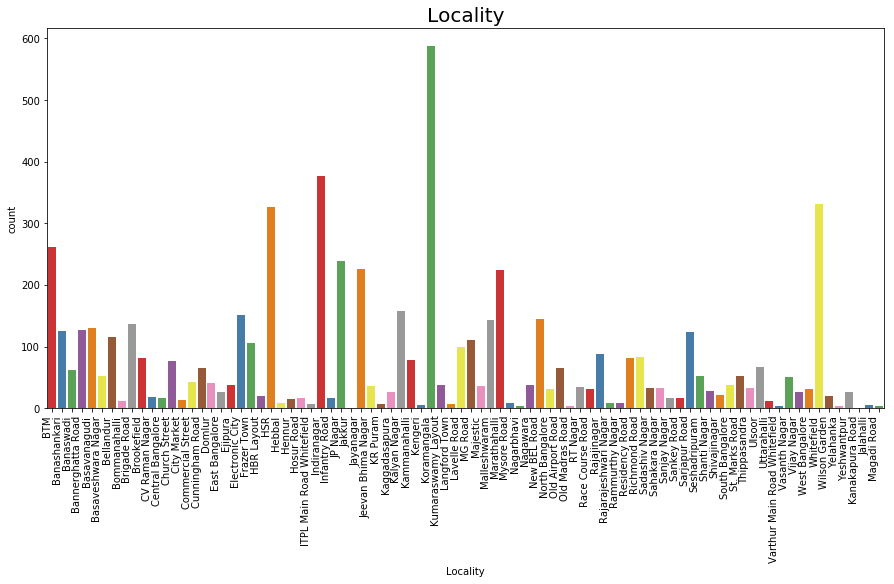

In [107]:
rcParams['figure.figsize'] = 15,7
g = sns.countplot(x="Locality",data=blore_venues, palette = "Set1")
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
g 
plt.title('Locality',size = 20)

### Restaurant type distribution plot

Text(0.5, 1.0, 'Venue Category')

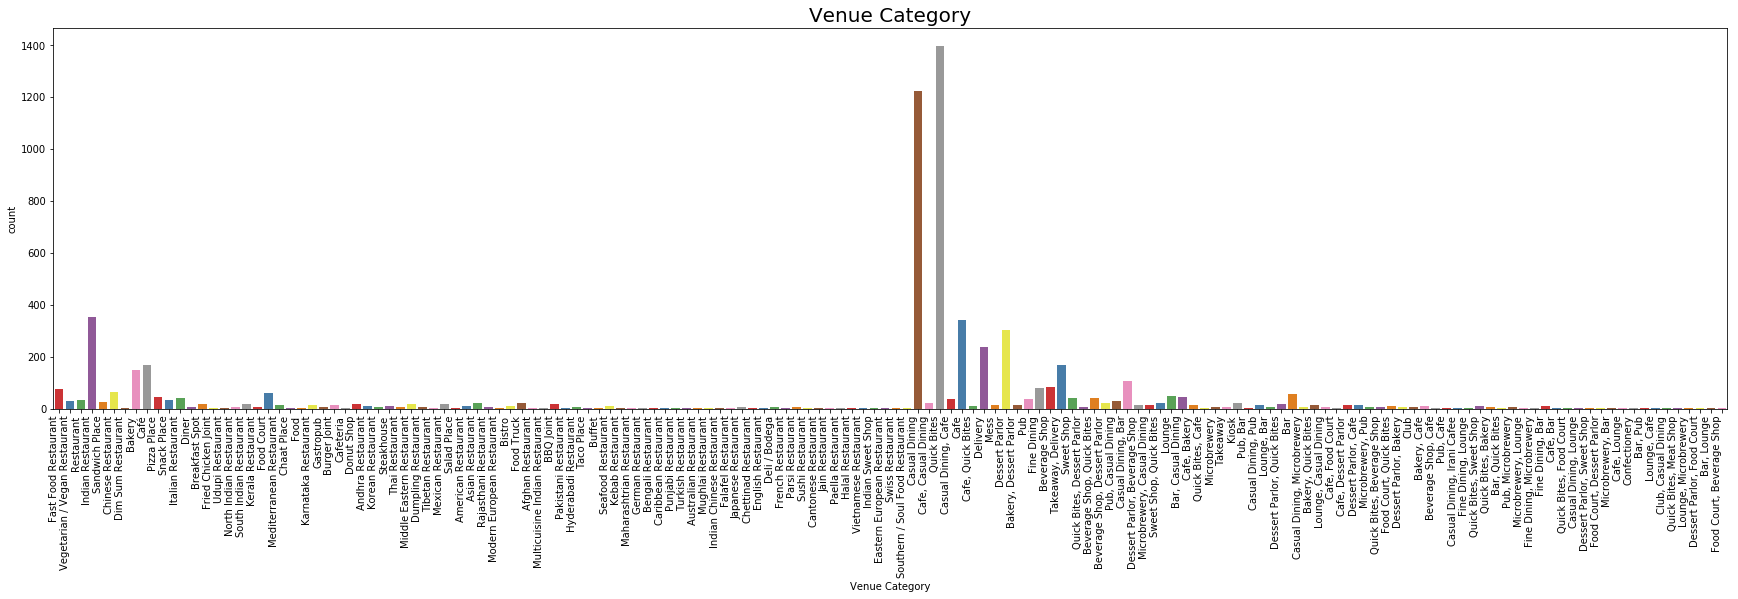

In [108]:
rcParams['figure.figsize'] = 30,7
g = sns.countplot(x="Venue Category",data=blore_venues, palette = "Set1")
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
g 
plt.title('Venue Category',size = 20)



## Analyze Each Neighborhood

In [109]:
# one hot encoding
blore_onehot = pd.get_dummies(blore_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
blore_onehot['Locality'] = blore_venues['Locality'] 

# move neighborhood column to the first column
fixed_columns = [blore_onehot.columns[-1]] + list(blore_onehot.columns[:-1])
blore_onehot = blore_onehot[fixed_columns]

blore_onehot.head()
blore_onehot.shape

(6160, 153)

In [110]:
blore_grouped = blore_onehot.groupby('Locality').mean().reset_index()
blore_grouped.shape

(84, 153)

#### Let's print each neighborhood along with the top 5 most common venues

In [111]:
num_top_venues = 5

for hood in blore_grouped['Locality']:
    print("----"+hood+"----")
    temp = blore_grouped[blore_grouped['Locality'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----BTM----
                venue  freq
0         Quick Bites  0.35
1       Casual Dining  0.18
2  Takeaway, Delivery  0.08
3                Cafe  0.05
4      Dessert Parlor  0.04


----Banashankari----
            venue  freq
0     Quick Bites  0.38
1   Casual Dining  0.16
2            Cafe  0.10
3  Dessert Parlor  0.06
4        Delivery  0.06


----Banaswadi----
               venue  freq
0        Quick Bites  0.35
1      Casual Dining  0.21
2               Cafe  0.08
3         Food Court  0.03
4  Indian Restaurant  0.03


----Bannerghatta Road----
                venue  freq
0         Quick Bites  0.31
1       Casual Dining  0.20
2                Cafe  0.09
3  Takeaway, Delivery  0.08
4            Delivery  0.07


----Basavanagudi----
               venue  freq
0        Quick Bites  0.41
1      Casual Dining  0.15
2  Indian Restaurant  0.08
3     Dessert Parlor  0.08
4             Bakery  0.05


----Basaveshwara Nagar----
                  venue  freq
0           Quick Bites  0.23
1

Let's put that into a pandas dataframe

In [112]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [113]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Locality']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Locality'] = blore_grouped['Locality']

for ind in np.arange(blore_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(blore_grouped.iloc[ind, :], num_top_venues)
pd.set_option('display.max_rows', 100)
neighbourhoods_venues_sorted

,Locality,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BTM,Quick Bites,Casual Dining,"Takeaway, Delivery",Cafe,Dessert Parlor,Delivery,Beverage Shop,Indian Restaurant,Bakery,Chinese Restaurant
1,Banashankari,Quick Bites,Casual Dining,Cafe,Dessert Parlor,Delivery,Indian Restaurant,"Takeaway, Delivery",Café,Bakery,Sweet Shop
2,Banaswadi,Quick Bites,Casual Dining,Cafe,Food Court,Bakery,Dessert Parlor,Delivery,Indian Restaurant,Bar,Mess
3,Bannerghatta Road,Quick Bites,Casual Dining,Cafe,"Takeaway, Delivery",Delivery,Dessert Parlor,Food Court,"Casual Dining, Bar",Bakery,Kiosk
4,Basavanagudi,Quick Bites,Casual Dining,Indian Restaurant,Dessert Parlor,Bakery,Cafe,Café,Fast Food Restaurant,Beverage Shop,Restaurant
5,Basaveshwara Nagar,Quick Bites,Casual Dining,Dessert Parlor,Indian Restaurant,Fast Food Restaurant,"Casual Dining, Cafe",Snack Place,Café,Pizza Place,Delivery
6,Bellandur,Casual Dining,Quick Bites,Cafe,Dessert Parlor,Delivery,"Takeaway, Delivery",Kiosk,"Casual Dining, Bar",Bakery,"Bakery, Dessert Parlor"
7,Bommanahalli,Quick Bites,Indian Restaurant,Casual Dining,Bar,Delivery,South Indian Restaurant,"Dessert Parlor, Bakery",Dessert Parlor,Deli / Bodega,Confectionery
8,Brigade Road,Casual Dining,Indian Restaurant,Café,Quick Bites,Dessert Parlor,Chinese Restaurant,Fast Food Restaurant,Pizza Place,Food Court,Cafe
9,Brookefield,Quick Bites,Casual Dining,Bakery,Indian Restaurant,Cafe,Food Court,Dessert Parlor,Fast Food Restaurant,Beverage Shop,Sweet Shop


### Cluster localiities 

Run k-means to cluster the localities into 5 clusters.

In [114]:
# set number of clusters
kclusters = 5

blore_grouped_clustering = blore_grouped.drop('Locality', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(blore_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100] 

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 2, 3, 1, 3, 0, 1, 1, 1, 4, 0, 1, 1, 0, 0,
       0, 3, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 3, 0, 1, 1, 2, 3], dtype=int32)

In [115]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

blore_merged = blore_geo_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
blore_merged = blore_merged.join(neighbourhoods_venues_sorted.set_index('Locality'), on='Locality')
blore_merged = blore_merged[blore_merged['Cluster Labels'].notna()]
blore_merged['Cluster Labels'] = blore_merged['Cluster Labels'].apply(np.int64)
pd.set_option('display.max_rows', 100)
blore_merged # check the last columns!

,Locality,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BTM,12.916576,77.610116,1,Quick Bites,Casual Dining,"Takeaway, Delivery",Cafe,Dessert Parlor,Delivery,Beverage Shop,Indian Restaurant,Bakery,Chinese Restaurant
1,Banashankari,12.925453,77.546757,1,Quick Bites,Casual Dining,Cafe,Dessert Parlor,Delivery,Indian Restaurant,"Takeaway, Delivery",Café,Bakery,Sweet Shop
2,Banaswadi,13.010376,77.648194,1,Quick Bites,Casual Dining,Cafe,Food Court,Bakery,Dessert Parlor,Delivery,Indian Restaurant,Bar,Mess
3,Bannerghatta Road,12.839527,77.588861,1,Quick Bites,Casual Dining,Cafe,"Takeaway, Delivery",Delivery,Dessert Parlor,Food Court,"Casual Dining, Bar",Bakery,Kiosk
4,Basavanagudi,12.940600,77.573763,1,Quick Bites,Casual Dining,Indian Restaurant,Dessert Parlor,Bakery,Cafe,Café,Fast Food Restaurant,Beverage Shop,Restaurant
5,Basaveshwara Nagar,12.987958,77.537466,1,Quick Bites,Casual Dining,Dessert Parlor,Indian Restaurant,Fast Food Restaurant,"Casual Dining, Cafe",Snack Place,Café,Pizza Place,Delivery
6,Bellandur,12.930428,77.678404,1,Casual Dining,Quick Bites,Cafe,Dessert Parlor,Delivery,"Takeaway, Delivery",Kiosk,"Casual Dining, Bar",Bakery,"Bakery, Dessert Parlor"
7,Bommanahalli,12.902980,77.624194,1,Quick Bites,Indian Restaurant,Casual Dining,Bar,Delivery,South Indian Restaurant,"Dessert Parlor, Bakery",Dessert Parlor,Deli / Bodega,Confectionery
8,Brigade Road,12.970991,77.606900,0,Casual Dining,Indian Restaurant,Café,Quick Bites,Dessert Parlor,Chinese Restaurant,Fast Food Restaurant,Pizza Place,Food Court,Cafe
9,Brookefield,12.965480,77.718464,1,Quick Bites,Casual Dining,Bakery,Indian Restaurant,Cafe,Food Court,Dessert Parlor,Fast Food Restaurant,Beverage Shop,Sweet Shop


### Finally, let's visualize the resulting clusters

In [116]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(blore_merged['Latitude'], blore_merged['Longitude'], blore_merged['Locality'], blore_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters
Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

In [117]:
blore_merged.loc[blore_merged['Cluster Labels'] == 0, blore_merged.columns[[0] + list(range(4, blore_merged.shape[1]))]]

,Locality,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Brigade Road,Casual Dining,Indian Restaurant,Café,Quick Bites,Dessert Parlor,Chinese Restaurant,Fast Food Restaurant,Pizza Place,Food Court,Cafe
10,CV Raman Nagar,Indian Restaurant,Casual Dining,Quick Bites,Bakery,Food Court,Delivery,Café,"Food Court, Quick Bites","Takeaway, Delivery",BBQ Joint
11,Central Bangalore,Indian Restaurant,Sandwich Place,Food Truck,Fast Food Restaurant,Rajasthani Restaurant,Snack Place,South Indian Restaurant,Chinese Restaurant,Café,Chaat Place
12,Church Street,Casual Dining,Indian Restaurant,Café,Quick Bites,Cafe,"Casual Dining, Bar",Dessert Parlor,Chinese Restaurant,Lounge,Fast Food Restaurant
14,Commercial Street,Indian Restaurant,Quick Bites,Casual Dining,Fast Food Restaurant,Sweet Shop,Food Truck,South Indian Restaurant,American Restaurant,Beverage Shop,"Beverage Shop, Dessert Parlor"
15,Cunningham Road,Indian Restaurant,Casual Dining,Quick Bites,Chinese Restaurant,Dessert Parlor,Café,Italian Restaurant,Pizza Place,Multicuisine Indian Restaurant,Beverage Shop
16,Domlur,Casual Dining,Indian Restaurant,Quick Bites,Delivery,Café,Bar,Fine Dining,Pizza Place,"Casual Dining, Bar",Cafe
17,East Bangalore,Indian Restaurant,Food Truck,Bakery,BBQ Joint,Delivery,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Pakistani Restaurant,Café,Hyderabadi Restaurant
18,Ejipura,Indian Restaurant,Quick Bites,Italian Restaurant,Café,Chinese Restaurant,Fast Food Restaurant,Burger Joint,Buffet,Delivery,Diner
23,Hebbal,Indian Restaurant,Pizza Place,Quick Bites,Fast Food Restaurant,Bakery,Restaurant,"Casual Dining, Pub","Casual Dining, Microbrewery",Chaat Place,"Casual Dining, Lounge"


In [118]:
blore_merged.loc[blore_merged['Cluster Labels'] == 1, blore_merged.columns[[0] + list(range(4, blore_merged.shape[1]))]]

,Locality,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BTM,Quick Bites,Casual Dining,"Takeaway, Delivery",Cafe,Dessert Parlor,Delivery,Beverage Shop,Indian Restaurant,Bakery,Chinese Restaurant
1,Banashankari,Quick Bites,Casual Dining,Cafe,Dessert Parlor,Delivery,Indian Restaurant,"Takeaway, Delivery",Café,Bakery,Sweet Shop
2,Banaswadi,Quick Bites,Casual Dining,Cafe,Food Court,Bakery,Dessert Parlor,Delivery,Indian Restaurant,Bar,Mess
3,Bannerghatta Road,Quick Bites,Casual Dining,Cafe,"Takeaway, Delivery",Delivery,Dessert Parlor,Food Court,"Casual Dining, Bar",Bakery,Kiosk
4,Basavanagudi,Quick Bites,Casual Dining,Indian Restaurant,Dessert Parlor,Bakery,Cafe,Café,Fast Food Restaurant,Beverage Shop,Restaurant
5,Basaveshwara Nagar,Quick Bites,Casual Dining,Dessert Parlor,Indian Restaurant,Fast Food Restaurant,"Casual Dining, Cafe",Snack Place,Café,Pizza Place,Delivery
6,Bellandur,Casual Dining,Quick Bites,Cafe,Dessert Parlor,Delivery,"Takeaway, Delivery",Kiosk,"Casual Dining, Bar",Bakery,"Bakery, Dessert Parlor"
7,Bommanahalli,Quick Bites,Indian Restaurant,Casual Dining,Bar,Delivery,South Indian Restaurant,"Dessert Parlor, Bakery",Dessert Parlor,Deli / Bodega,Confectionery
9,Brookefield,Quick Bites,Casual Dining,Bakery,Indian Restaurant,Cafe,Food Court,Dessert Parlor,Fast Food Restaurant,Beverage Shop,Sweet Shop
13,City Market,Quick Bites,Casual Dining,Indian Restaurant,South Indian Restaurant,Food,Diner,Middle Eastern Restaurant,Food Truck,"Bakery, Cafe",Confectionery


In [119]:
blore_merged.loc[blore_merged['Cluster Labels'] == 2, blore_merged.columns[[0] + list(range(4, blore_merged.shape[1]))]]

,Locality,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Jakkur,Restaurant,"Club, Casual Dining","Dessert Parlor, Cafe","Dessert Parlor, Beverage Shop","Dessert Parlor, Bakery",Dessert Parlor,Delivery,Deli / Bodega,Confectionery,Vietnamese Restaurant
83,Yelahanka,Restaurant,Quick Bites,Vietnamese Restaurant,"Dessert Parlor, Beverage Shop","Dessert Parlor, Bakery",Dessert Parlor,Delivery,Deli / Bodega,Confectionery,"Club, Casual Dining"


In [120]:
blore_merged.loc[blore_merged['Cluster Labels'] == 3, blore_merged.columns[[0] + list(range(4, blore_merged.shape[1]))]]

,Locality,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Jalahalli,Quick Bites,"Sweet Shop, Quick Bites","Dessert Parlor, Food Court","Dessert Parlor, Beverage Shop","Dessert Parlor, Bakery",Dessert Parlor,Delivery,Deli / Bodega,Confectionery,"Club, Casual Dining"
33,Jeevan Bhima Nagar,Quick Bites,Casual Dining,Beverage Shop,Delivery,Cafe,Snack Place,Indian Restaurant,Donut Shop,Vietnamese Restaurant,Confectionery
45,Magadi Road,Casual Dining,Quick Bites,"Casual Dining, Irani Cafee","Club, Casual Dining","Dessert Parlor, Beverage Shop","Dessert Parlor, Bakery",Dessert Parlor,Delivery,Deli / Bodega,Confectionery
79,Vijay Nagar,Quick Bites,Casual Dining,"Casual Dining, Bar",Hyderabadi Restaurant,"Quick Bites, Beverage Shop",Cafe,Snack Place,Breakfast Spot,Sweet Shop,Fine Dining
84,Yeshwantpur,Quick Bites,Casual Dining,Multicuisine Indian Restaurant,"Casual Dining, Bar",Restaurant,Dessert Parlor,Delivery,Cafe,Karnataka Restaurant,"Quick Bites, Sweet Shop"


In [121]:
blore_merged.loc[blore_merged['Cluster Labels'] == 4, blore_merged.columns[[0] + list(range(4, blore_merged.shape[1]))]]

,Locality,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
38,Kanakapura Road,Casual Dining,"Club, Casual Dining","Dessert Parlor, Cafe","Dessert Parlor, Beverage Shop","Dessert Parlor, Bakery",Dessert Parlor,Delivery,Deli / Bodega,Confectionery,Club
